In [86]:
load("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/Nissle_processed.RData")
load("colibactinFig1.RData")
library(tidyverse)
library(reshape2)
library(magrittr)
library(lemon)
library(BSgenome)
library(MutationalPatterns)
library(plyr)
library(data.table)
library(vroom)
library(ggpubr)
library(cowplot)
library(patchwork)
library(BSgenome.Hsapiens.UCSC.hg38)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(sjPlot)
library(ggseqlogo)
library(ggplot2)
library(gtools)
library(ggh4x)
library(ggridges)
library(dtplyr)
library(ggpp)
library(geomtextpath)

ref_genome = "BSgenome.Hsapiens.UCSC.hg38"
genes = genes(TxDb.Hsapiens.UCSC.hg38.knownGene)


  2169 genes were dropped because they have exons located on both strands of
  the same reference sequence or on more than one reference sequence, so cannot
  be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a GRangesList
  object, or use suppressMessages() to suppress this message.



In [ ]:
# function to make the script a bit shorter:

get_profile_labels = function(ext_context, TN_signature) {

  context_counts = ext_context %>%
    group_by(name, select, trinucleotide) %>%
    dplyr::count() %>%
    pivot_wider(values_from = n, names_from = trinucleotide, values_fill = 0) %>%
    ungroup() %>% as.data.table()

  # get the trinucleotide profile for the total samples:
  type_counts_all = context_counts[, lapply(.SD, sum), by = c("name"),
                                   .SDcols = names(context_counts) %like% "[.>.]"]
  type_counts_all = type_counts_all %>%
    column_to_rownames("name") %>%
    t() %>% as.data.frame()
  type_counts_all = type_counts_all[TRIPLETS_48,]
  cosines_TN = sapply(type_counts_all, cos_sim, TN_signature)
  spearman_TN = sapply(type_counts_all, cor, TN_signature, method = "spearman") # get cosine similarities to SBS T>N fraction
  spearman_TN_pval = sapply(type_counts_all, \(x) cor.test(x, TN_signature, method = "spearman")$p.value) %>%
    p.adjust(method = 'fdr') %>%
    formatC(format = "e", digits = 2)# get spearman correlation


  TN_trinuc_counts = context_counts %>% filter(select == "AA") %>%
    dplyr::select(-select) %>% column_to_rownames("name") %>%
    t() %>% as.data.frame()
  TN_trinuc_counts = TN_trinuc_counts[TRIPLETS_48,]

  cosines_TN_AA = sapply(TN_trinuc_counts, cos_sim, TN_signature)
  spearman_TN_AA = sapply(TN_trinuc_counts, cor, TN_signature, method = "spearman")
  spearman_TN_AA_pval = sapply(TN_trinuc_counts, \(x) cor.test(x, TN_signature, method = "spearman")$p.value) %>%
    p.adjust(method = 'fdr') %>%
    formatC(format = "e", digits = 2)# get cosine similarities to SBS T>N fraction


  label_df = data.frame(name = factor(names(cosines_TN), levels = names(cosines_TN)),
                        cosine_TN = cosines_TN,
                        spearman_TN = spearman_TN,
                        cosine_TN_AA = cosines_TN_AA,
                        spearman_TN_AA = spearman_TN_AA,
                        label_cosine = paste0("all T>N: ", round(cosines_TN, 2),
                                              "\nT>N -3-4AA: ", round(cosines_TN_AA, 2)),
                        label_spearman = paste0(round(spearman_TN, 2) ,
                                       "\n", round(spearman_TN_AA, 2)),
                        label_pval = paste0(spearman_TN_pval, "\n", spearman_TN_AA_pval))

  return(label_df)
}


In [ ]:
contexts_TN = list()
for (type in names(context_list)) {
  ctx_table= context_list[[type]] %>%
    rbindlist() %>%
    distinct() %>%
    filter(grepl("^T", type))
  contexts_TN[[type]] = ctx_table
}

In [ ]:
cat_CE = categories %>%
  filter(method == "Crypt")
cat_CE$injection = factor(cat_CE$injection, levels = c("normal", "adenoma"))

In [90]:
contexts_TN_CE = list()
for (type in unique(cat_CE$injection)) {
  ctx_table= context_list[[type]] %>%
    rbindlist(idcol = "samplename") %>%
    filter(samplename %in% cat_CE$name) %>%
    dplyr::select(-samplename) %>%
    distinct() %>%
    filter(grepl("^T", type))
  contexts_TN_CE[[type]] = ctx_table
}

In [ ]:
TRIPLETS_48 = TRIPLETS_96[49:96]
SBS88_TN <- as.data.table(signatures) %>% dplyr::slice(49:96) %>% pull("SBS88")

In [ ]:
ext_context = rbindlist(contexts_TN_CE,, idcol = "name") %>%
    mutate(pos34 =  substr(context, 7,8)) %>%
    mutate(trinucleotide = factor(trinucleotide, levels = TRIPLETS_48)) %>%
    mutate(select =  ifelse(pos34 == "AA", "AA", "other") %>%
             factor(levels = c("other", "AA"))) %>%
    mutate(name = name %>% factor(levels = levels(cat$injection)))

In [95]:
contexts_TN_sample <- setNames(
  contexts_TN_sample,
  names(contexts_TN_sample)
)
ext_context_sample <- rbindlist(
  contexts_TN_sample,
  idcol = "name"
)

ext_context_sample <- ext_context_sample %>%
  mutate(
    pos34 = substr(context, 7, 8),
    trinucleotide = factor(trinucleotide, levels = TRIPLETS_48),
    select = factor(
      ifelse(pos34 == "AA", "AA", "other"),
      levels = c("other", "AA")
    ),
  )

ERROR: Error: object 'contexts_TN_sample' not found


In [ ]:
label_df = get_profile_labels(ext_context, SBS88_TN)
  # Add the explaining label on the plot:
  label_df$label_cosine = paste0("SBS88:    cosine similarity\n", label_df$label_cosine)
  label_df$label_spearman = paste0("spearman\n", label_df$label_spearman)
  label_df$label_pval = paste0("pval\n", label_df$label_pval)

In [ ]:
label_df

In [ ]:
F3e_AA_context_profile <- ext_context %>%
      mutate(select =  fct_recode(select, "-3-4AA" = "AA")) %>%
      group_by(trinucleotide, select) %>%
      ggplot(aes(x = trinucleotide, alpha = select, fill = type)) +
      geom_bar(width = 0.7 ) +
      facet_grid(name ~ . , scales  = "free_y") +
      theme_BM()  +
      scale_alpha_manual(values = c(0.3, 1)) +
      scale_fill_manual(values = COLORS6[4:6]) +
      theme(legend.position = "top",
            legend.box = "horizontal",
            axis.text.x = element_text(size= 6.5, angle = 90, vjust = 0.5, hjust=1),
            legend.box.background = element_rect(colour = "black", fill = NA),
            legend.background =element_blank(),
            legend.text = element_text(size=7),
            legend.title = element_blank(),
            strip.background = element_blank(),
            strip.text.y = element_blank(),
            legend.key.size = unit(7, "points"),
            plot.margin = margin(unit(c(3, 8, 8, 8), "points"))) +
      xlab("") + ylab("Mutation count") +
    labs(alpha = "nucs at pos -3-4", fill = NULL) +
    ggpp::geom_text_npc(data = label_df, npcx = 0.98, npcy = 0.9,
                        aes(label = label_pval), size = 2.5, hjust = 1) +
    ggpp::geom_text_npc(data = label_df, npcx = 0.88, npcy = 0.9,
                        aes(label = label_spearman), size = 2.5, hjust = 1) +
    ggpp::geom_text_npc(data = label_df, npcx = 0.78, npcy = 0.9,
                       aes(label = label_cosine), size = 2.5, hjust = 1) +
      ggpp::geom_text_npc(data = label_df, npcx = 0.02, npcy = 0.9,
                        aes(label = name), size = 3.5, hjust = 0)

In [ ]:
F3e_AA_context_profile

In [ ]:
list = split(ext_context, ext_context$name)
  occurrence_mat = sapply(list, function(x) table(x$select))
  AA_occurrence_mat_percentages = occurrence_mat[2,] / colSums(occurrence_mat)

  # get the enrichment scores for only A mutations at the -3 site:
  list3 = list %>% rbindlist() %>%
    mutate(pos3 = substr(pos34, 2,2))

  occurrence_mat_A = table(list3$name, list3$pos3) %>% as.data.frame.matrix()
  A_occurrence_mat_percentages = occurrence_mat_A[,1] / rowSums(occurrence_mat_A)
  AA_occurrence_mat_percentages /A_occurrence_mat_percentages

  # perform fisher test on all motif enrichments
  dinuc_counts = sapply(list, function(x) table(x$pos34))

In [ ]:
colnames(dinuc_counts) = paste0(colnames(dinuc_counts), "\n", colSums(dinuc_counts)," T>N SBS")
  dinuc_long = prop.table(dinuc_counts, 2) %>%
    data.table(keep.rownames = "Dinucleotide") %>%
    mutate(color = ifelse(Dinucleotide == "AA", "AA", "noAA")) %>%
    pivot_longer(cols = c(-Dinucleotide, -color), names_to = "Condition", values_to = "relative frequency") %>%
    mutate(Condition = factor(Condition, levels = colnames(dinuc_counts)))

  F3c_dinuc_frequencies = ggplot(dinuc_long) +
    geom_bar(aes(x = Dinucleotide, y = `relative frequency`, fill = color), stat = "identity") +
    facet_grid(. ~ Condition , scales = "free_y") +
    theme_classic() +  panel_border()  +
    scale_y_continuous(expand = c(0, 0), limits = c(0,0.75), breaks = seq(0, 0.75, 0.25)) +
    scale_fill_manual(values = c("darkgreen", "gray30")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,  size = 6 ),
          strip.text.x = element_text(size = 7),
          legend.position = "none", panel.spacing.x = unit(1, units = "mm"),
          plot.margin = margin(unit(c(3, 3, 3, 3), "points")))  +
    ylab("relative frequency") + xlab("")
  F3c_dinuc_frequencies

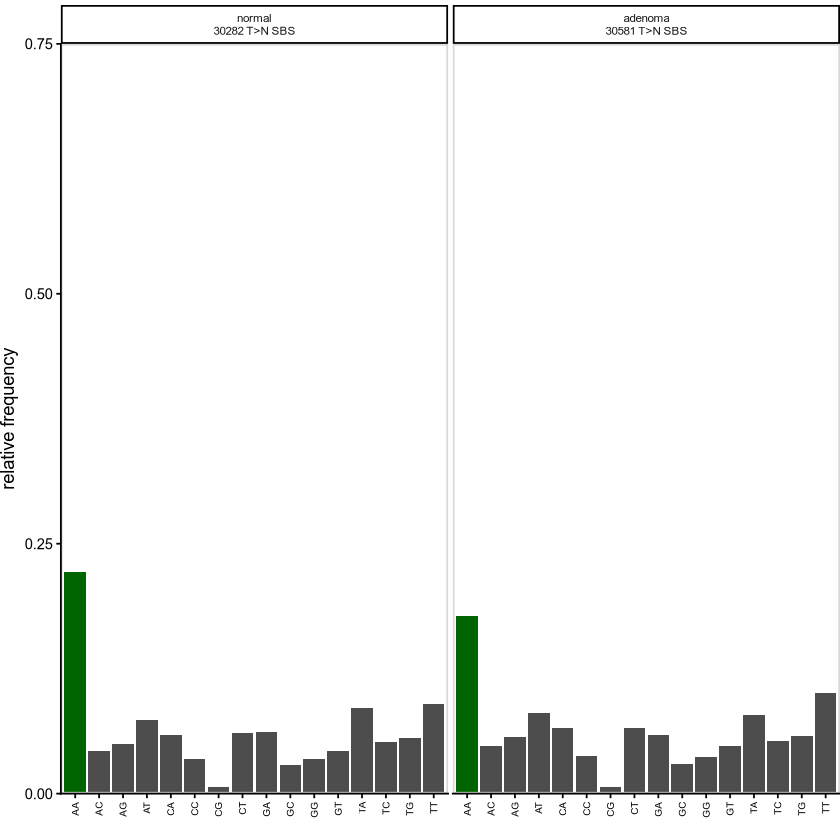

In [81]:
  F3c_dinuc_frequencies

In [ ]:
TNctx = list()
  for (type in levels(cat$injection)) {
    type_context = contexts_TN[[type]]$context
    TNctx[[type]] = type_context
  }

  TNctx = TNctx[c("normal", "adenoma")]
  TNctx = TNctx[1:length(levels(cat$injection))]

  labels = data.frame(seq_group = factor(names(TNctx), names(TNctx)),
                      label = paste0(names(TNctx), "\nT>N SBS:\n", lengths(TNctx)))

  F3a_seqlogo_plots = ggseqlogo(TNctx) +
    annotate('rect', xmin = 10.5, xmax = 11.5, ymin = 0, ymax = 0.3, fill='grey') +
    scale_x_continuous(breaks = c(1:21), labels= c(-10:10)) +
    scale_y_continuous(limits = c(0,1.2), expand = c(0,0), breaks = c(0, 0.5, 1)) +
    ggpp::geom_text_npc(data = labels, aes(label = label),
                        npcx = 0.02, npcy = 0.95, hjust = 0, size = 3) +
    xlab("") +
    theme_BM() +
    theme( strip.background = element_blank(),
                        strip.text.x = element_blank(),
           axis.text.x = element_text(size = 6, angle = 90, vjust = 0.5, hjust=1),
           plot.margin = margin(20, 8, 8, 8, unit = "pt"))
  F3a_seqlogo_plots


In [83]:
dinuc_counts

,normal 30282 T>N SBS,adenoma 30581 T>N SBS
AA,6709,5447
AC,1286,1452
AG,1517,1731
AT,2226,2460
CA,1784,1996
CC,1058,1136
CG,198,216
CT,1834,1999
GA,1873,1804
GC,880,909


In [ ]:
p_value_AA = ggplot(metadata, aes(x = AA, y = log_p_wgs, color = rec_tissues)) + geom_point(alpha = 0.7) +
  geom_hline(yintercept = 3) + geom_vline(xintercept = 0.22) +
  scale_color_manual(values = c("lightblue", "#d95f02", "#1b9e77",  "#bdbdbd", "#7570b3", "black", "maroon", 'pink', 'violet'), name = "Primary cancer origin") +
  scale_shape_discrete(name = "Pks classification", labels = c("pks negative", "pks+ established", "pks+ new")) +
  xlab("fraction mutations with AA at\n-3-4 position at pks-sites") + ylab("-log10 p-value") +
  theme_classic()